#  Optimization for Machine Learning – Homework Part 1
### Objectif

Comparer deux variantes de l'accélération de Nesterov sur la **fonction de Rosenbrock** (non convexe) :

- **Vanishing Friction (VF)** : $\beta_k = \frac{k}{k + b}$ — inertie croissante asymptotiquement vers 1
- **Speed Restart (SR)** : $\beta_j = \frac{j}{j + b}$ avec **redémarrage** ($j \leftarrow 0$) lorsque :
  $$\|x_{k+1} - x_k\| < \|x_k - x_{k-1}\| \quad \text{et} \quad j \geq k_{\min}$$

### Protocole expérimental

**Algorithme de Nesterov (NAG)** :
$$\begin{cases}
y_k = x_k + \beta_k (x_k - x_{k-1}) \\
x_{k+1} = y_k - \alpha \nabla f(y_k)
\end{cases}$$

**Paramètres** :
- $b = 3$ : paramètre de friction
- $k_{\min} = 20$ : nombre minimal d'itérations avant autorisation de redémarrage (SR uniquement)
- $\alpha$ : pas d'apprentissage (grille de valeurs testées)


In [2]:
#Configuration

import torch
import matplotlib.pyplot as plt
import numpy as np

torch.set_default_dtype(torch.float32)

def rosenbrock(x):
    """Fonction de Rosenbrock en 2D."""
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2



In [3]:
def _nag_step(x: torch.Tensor,
              x_prev: torch.Tensor,
              beta: float,
              lr: float):
    """
    Une itération Nesterov :
    y = x + beta*(x - x_prev)
    x_next = y - lr * grad f(y)
    On renvoie x_next et f(x_next) pour logger la vraie perte après update.
    """
    # Point inertiel
    y = x + beta * (x - x_prev)

    # Gradient de f au point y 
    y_req = y.detach().requires_grad_(True)
    loss_y = rosenbrock(y_req)
    grad_y = torch.autograd.grad(loss_y, y_req)[0]

    # Mise à jour
    x_next = y_req - lr * grad_y
    loss_next = rosenbrock(x_next).item()

    return x_next.detach(), loss_next

In [4]:
def run_vanishing_friction(lr=1e-3, b=3.0, T=3000, x0=-1.2, y0=1.0):
    """
    Vanishing Friction : (β_k = k/(k+b))
    """
    x_prev = torch.tensor([x0, y0])
    x = x_prev.clone()

    hist = {"x": [], "loss": []}

    for k in range(1, T + 1):
        beta = k / (k + b)
        x_next, loss_next = _nag_step(x, x_prev, beta, lr)

        hist["x"].append(x_next.clone())
        hist["loss"].append(loss_next)

        x_prev, x = x, x_next

    return hist

In [5]:
def run_speed_restart(lr=1e-3, b=3.0, T=3000, kmin=20, x0=-1.2, y0=1.0):
    """
    Speed Restart : β_j = j/(j+b) avec compteur j remis à 0
    quand ||x_{k+1}-x_k|| < ||x_k-x_{k-1}|| et j >= kmin.
    """
    x_prev = torch.tensor([x0, y0])
    x = x_prev.clone()
    j = 0  # compteur pour β_j

    hist = {"x": [], "loss": [], "restarted": []}

    for _ in range(1, T + 1):
        beta = j / (j + b) if j > 0 else 0.0
        x_next, loss_next = _nag_step(x, x_prev, beta, lr)

        # Log
        hist["x"].append(x_next.clone())
        hist["loss"].append(loss_next)

        # Critère de redémarrage (speed restart)
        restarted = False
        if torch.norm(x_next - x) < torch.norm(x - x_prev) and j >= kmin:
            j = 0
            restarted = True
        else:
            j += 1
        hist["restarted"].append(restarted)

        x_prev, x = x, x_next

    return hist

In [6]:
def plot_learning_rate_comparison(lrs, run_fn, title="Comparaison"):
    """
    Compare différents learning rates sur f(x_k).
    - lrs : liste de valeurs à tester
    - run_fn : fonction d'entraînement 
    """
    plt.figure(figsize=(6,4))

    for lr in lrs:
        hist = run_fn(lr=lr)
        losses = np.array(hist["loss"])
        plt.semilogy(losses, lw=1.8, label=f"$\\alpha = {lr:g}$")

    plt.xlabel("Itérations", fontsize=12)
    plt.ylabel("$f(x_k)$", fontsize=12)
    plt.title(title, fontsize=13, pad=10)
    plt.legend(fontsize=10, frameon=False)
    plt.grid(True, which="both", ls="--", lw=0.5, alpha=0.4)
    plt.tight_layout()
    plt.show()



In [7]:
def plot_convergence(hist_vf,hist_sr,title ="Comparaison de la convergence des algorithmes"):
    """
    Compararer la convergence des deux algorithmes"
    - hist_vf : historique de Vanishing Friction
    - hist_sr : historique de Speed Restart
    """
    plt.semilogy(hist_vf["loss"], label="Vanishing Friction (b=3)")
    plt.semilogy(hist_sr["loss"], label="Speed Restart (b=3)")
    plt.xlabel("Iteration"); plt.ylabel("f(x)")
    plt.title(title);plt.legend(); plt.show()


In [14]:
def _grid_rosenbrock(x_paths, y_paths, pad=0.3, n=400):
    """
    Construit une grille adaptée aux trajectoires observées.
    """
    x_min = min(np.min(p) for p in x_paths) - pad
    x_max = max(np.max(p) for p in x_paths) + pad
    y_min = min(np.min(p) for p in y_paths) - pad
    y_max = max(np.max(p) for p in y_paths) + pad

    XX, YY = np.meshgrid(np.linspace(x_min, x_max, n),
                         np.linspace(y_min, y_max, n))
    ZZ = (1 - XX)**2 + 100*(YY - XX**2)**2
    return XX, YY, ZZ


def _xy_from_hist(hist):
    """
    Extrait les coordonnées (x1, x2)
    """
    X = torch.stack(hist["x"]).cpu().numpy()
    return X[:, 0], X[:, 1]

def plot_trajectories(hist_vf, hist_sr, title="Trajectoires des algorithmes sur Rosenbrock"):
    x_vf, y_vf = _xy_from_hist(hist_vf)
    x_sr, y_sr = _xy_from_hist(hist_sr)

    XX, YY, ZZ = _grid_rosenbrock([x_vf, x_sr], [y_vf, y_sr])

    plt.figure(figsize=(7, 6))
    plt.contour(XX, YY, ZZ, levels=np.logspace(-2, 3, 20),
                cmap='viridis', linewidths=0.7)

    plt.plot(x_sr, y_sr,  '-', lw=1.8, color='yellow',  alpha=0.95, label="Speed Restart")
    plt.plot(x_vf, y_vf, '--', lw=1.8, color='green', alpha=0.95, label="Vanishing Friction ")

    plt.scatter([x_vf[0]], [y_vf[0]], s=110, c='k', label="Start (x₀)")
    plt.scatter([1], [1], s=230, c='k', marker='*', label="Minimum")

    plt.gca().set_aspect("equal", "box")
    plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

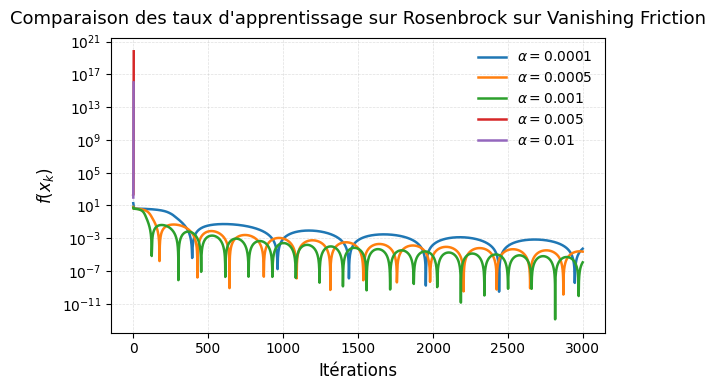

In [9]:
plot_learning_rate_comparison(
    lrs=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
    run_fn=run_vanishing_friction,
    title="Comparaison des taux d'apprentissage sur Rosenbrock sur Vanishing Friction"
)


### Interprétation

Ce graphique illustre le comportement de **Vanishing Friction** pour différentes valeurs de $\alpha$ sur la fonction de Rosenbrock.

**Observations** :

- **Régime stable** ($\alpha \in \{0.0001, 0.0005, 0.001\}$) : convergence globale, mais avec des **oscillations périodiques prononcées**. La valeur de $f(x_k)$ décroît fortement, puis remonte temporairement avant de se stabiliser à un niveau inférieur.

- **Origine des oscillations** : l'inertie croissante $\beta_k = \frac{k}{k+b}$ s'approche asymptotiquement de 1, amplifiant progressivement les déplacements. Cette accumulation de moment peut temporairement "dépasser" la vallée de Rosenbrock, provoquant des rebonds périodiques.

- **Régime instable** ($\alpha \geq 0.005$) : divergence immédiate.

- **Pas optimal** : $\alpha = 0.001$ offre le meilleur compromis, avec une convergence vers $f(x_k) \approx 10^{-12}$ malgré les oscillations.

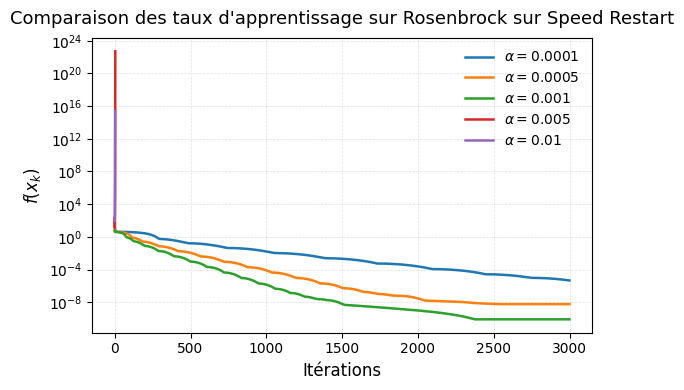

In [10]:
plot_learning_rate_comparison(
    lrs=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
    run_fn=run_speed_restart,
    title="Comparaison des taux d'apprentissage sur Rosenbrock sur Speed Restart"
)

### Interprétation

Ce graphique illustre l'influence du pas d'apprentissage $\alpha$ sur la convergence de **Speed Restart** appliqué à la fonction de Rosenbrock.

**Observations** :

- **Régime stable** ($\alpha \in \{0.0001, 0.0005, 0.001\}$) : convergence monotone en échelle logarithmique. La vitesse de convergence croît avec $\alpha$.

- **Régime critique** ($\alpha = 0.005$) : divergence explosive dès les premières itérations, avec $f(x_k)$ atteignant $10^{24}$.

- **Pas optimal** : $\alpha = 0.001$ offre le meilleur compromis **rapidité/stabilité**, atteignant $f(x_k) \approx 10^{-12}$ en 3000 itérations.

**Interprétation théorique** :

Ce comportement reflète la **condition de stabilité** de la descente de gradient avec accélération de Nesterov : 

$$\alpha < \frac{2}{L}$$

où $L$ est la constante de Lipschitz du gradient de Rosenbrock. Au-delà de ce seuil, l'inertie amplifie les erreurs de direction et provoque une divergence rapide. À l'inverse, un pas trop conservateur ($\alpha = 0.0001$) ralentit considérablement la convergence sans apporter de gain en stabilité.

Le mécanisme de **redémarrage** du Speed Restart permet de détecter et corriger partiellement les oscillations, mais ne peut compenser un pas excessivement grand.

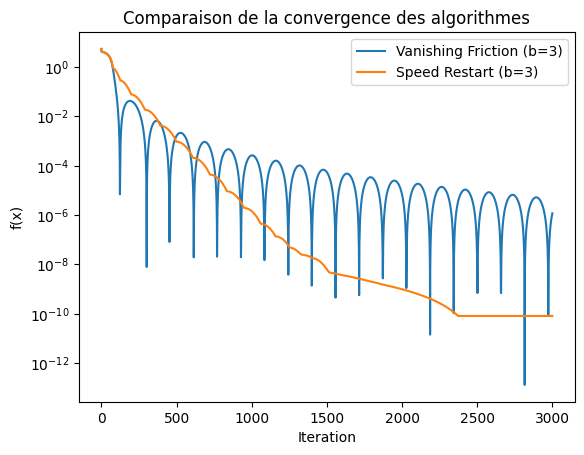

In [12]:
hist_vf = run_vanishing_friction()
hist_sr = run_speed_restart()
    
plot_convergence(hist_vf,hist_sr)

### Comparaison

Ce graphique compare directement la convergence de **Vanishing Friction (VF)** et **Speed Restart (SR)** sur la fonction de Rosenbrock.

- Les deux méthodes atteignent une **erreur très faible** (~10⁻¹⁰), mais leur comportement diffère :
  - **Vanishing Friction** présente des **oscillations importantes** : l’inertie βₖ croît continûment, ce qui provoque des “rebonds” autour du minimum.
  - **Speed Restart**, grâce à son **mécanisme de redémarrage**, amortit ces oscillations et stabilise la descente plus rapidement.
- À long terme, **SR converge plus vite** et de façon plus régulière, tandis que **VF** reste plus instable bien qu’efficace sur la tendance globale.

En résumé :  
> Le redémarrage de Speed Restart permet de conserver la vitesse du Nesterov classique tout en **corrigeant les excès d’inertie** observés dans Vanishing Friction.


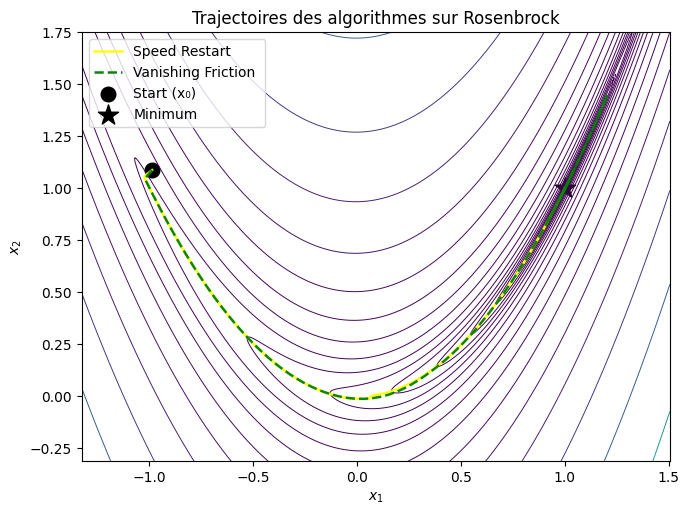

In [15]:
plot_trajectories(hist_vf,hist_sr)

### Interprétation et conclusion

Cette figure illustre les **trajectoires de Vanishing Friction (VF)** et **Speed Restart (SR)** sur la fonction de Rosenbrock, visualisées dans le plan \((x_1, x_2)\).

- Les deux méthodes suivent le **vallon étroit** caractéristique de Rosenbrock jusqu’au minimum global \((1, 1)\).  
- La trajectoire **Vanishing Friction (vert)** présente une **dynamique oscillante autour du minimum** :  
  lorsque l’inertie βₖ augmente continûment, le point dépasse le minimum, puis **revient en sens inverse**.
  Ce phénomène correspond à un **sur-ajustement inertiel** : le mouvement continue “trop loin” avant de se corriger.
- La trajectoire **Speed Restart (jaune)** est **plus régulière et maîtrisée** : les redémarrages empêchent ces dépassements, maintenant une progression plus directe et stable vers le minimum.

---

### Conclusion générale 

- **Vanishing Friction** : rapide mais oscillante, sensible aux pas trop grands, inertie parfois excessive.  
- **Speed Restart** : conserve la vitesse du Nesterov tout en **corrigeant les excès d’inertie** grâce aux redémarrages conditionnels.  
- Les deux atteignent le minimum, mais **Speed Restart offre un meilleur compromis entre vitesse et stabilité**.

> En résumé : le redémarrage adaptatif rend la méthode de Nesterov plus robuste et efficace sur les problèmes non convexes comme Rosenbrock.
